## ASSIGNMENT TASKS (placeholders in code at correct locations):
### 1. Perform Exploratory Data Analysis (EDA) to gain insights into the dataset.
####    Provide visualizations and summary statistics of the variables. Pre-process the data
####    to apply the Multiple Linear Regression (MLR).
##
### 2. Split the dataset into training and testing sets (e.g., 80% training, 20% testing).
#
### 3. Build a multiple linear regression model using the training dataset.
####    Interpret the coefficients of the model. Build a minimum of 3 different models.
##
### 4. Evaluate the performance of the model using appropriate evaluation metrics on the testing dataset.
#
### 5. Apply Lasso and Ridge methods on the model and compare results.

In [1]:
# Libraries for data handling, visualization, modelling and diagnostics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [2]:
# Load dataset to examine structure before any changes.
autos_df = pd.read_csv("/Users/tonystark/Desktop/Data_Science/CSV_files/ToyotaCorolla - MLR.csv")

In [3]:
autos_df.shape

(1436, 11)

In [4]:
autos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1436 non-null   int64 
 1   Age_08_04  1436 non-null   int64 
 2   KM         1436 non-null   int64 
 3   Fuel_Type  1436 non-null   object
 4   HP         1436 non-null   int64 
 5   Automatic  1436 non-null   int64 
 6   cc         1436 non-null   int64 
 7   Doors      1436 non-null   int64 
 8   Cylinders  1436 non-null   int64 
 9   Gears      1436 non-null   int64 
 10  Weight     1436 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 123.5+ KB


In [5]:
autos_df.head()

,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170


In [6]:
# Check for missing and duplicated data to spot data quality issues.
autos_df.isnull().sum()

Price        0
Age_08_04    0
KM           0
Fuel_Type    0
HP           0
Automatic    0
cc           0
Doors        0
Cylinders    0
Gears        0
Weight       0
dtype: int64

In [7]:
autos_df.duplicated().sum()

np.int64(1)

In [8]:
# Remove exact duplicate rows because duplicates distort learned relationships.
autos_df.drop_duplicates(inplace=True)

In [9]:
autos_df.duplicated().sum()

np.int64(0)

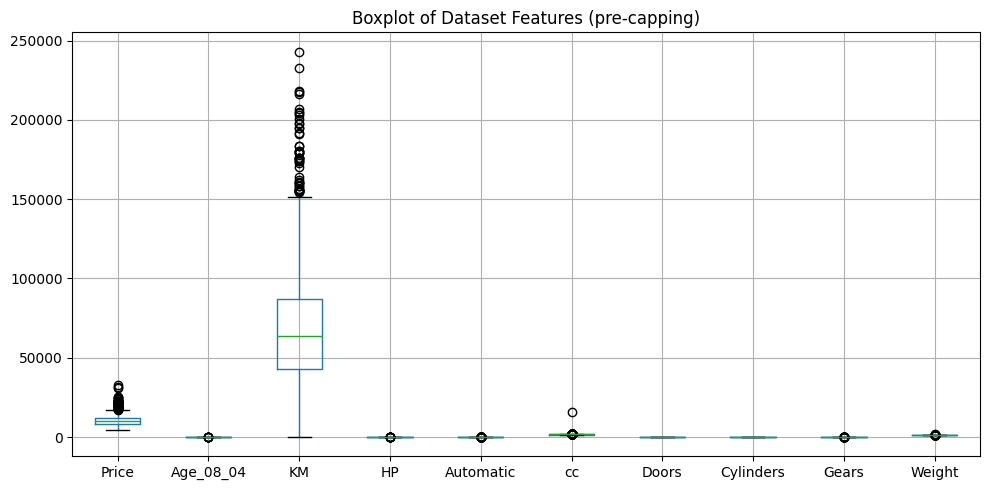

In [10]:
# Visualize spread and extremes to decide if capping is needed.
plt.figure(figsize=(10, 5))
autos_df.boxplot()
plt.title("Boxplot of Dataset Features (pre-capping)")
plt.tight_layout()
plt.show()

In [11]:
# Limit extreme values so they don't dominate mean-based model estimates.
def cap_outliers_iqr_method(dataframe, col_name):
    q1 = dataframe[col_name].quantile(0.25)
    q3 = dataframe[col_name].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    dataframe[col_name] = dataframe[col_name].apply(
        lambda v: lower if v < lower else (upper if v > upper else v)
    )

In [12]:
# Apply IQR capping to all numeric features to reduce extreme influence.
for column in autos_df.select_dtypes(['int', 'float']).columns:
    cap_outliers_iqr_method(autos_df, column)

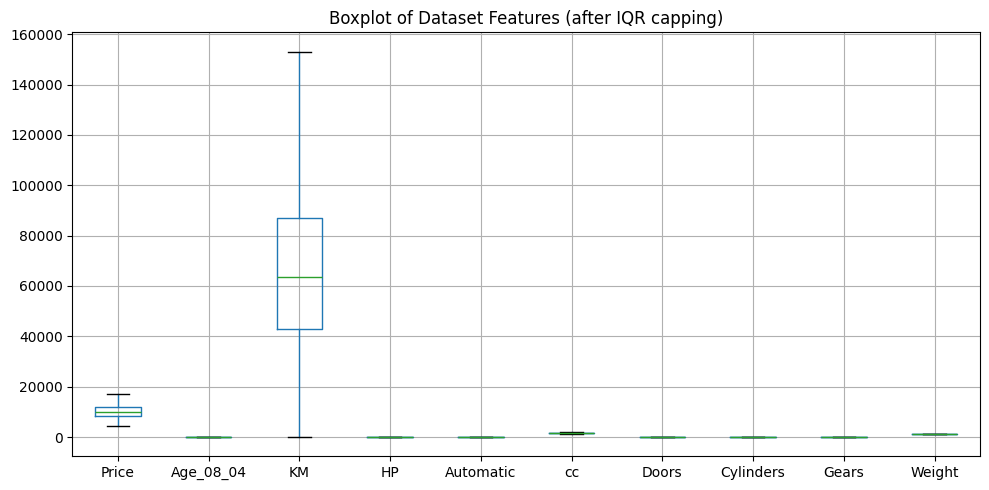

In [13]:
# Confirm distribution after capping to ensure extremes are controlled.
plt.figure(figsize=(10, 5))
autos_df.boxplot()
plt.title("Boxplot of Dataset Features (after IQR capping)")
plt.tight_layout()
plt.show()

In [14]:
# Convert categorical fuel labels into numeric codes so models can use them.
encoder = LabelEncoder()
autos_df['Fuel_Type'] = encoder.fit_transform(autos_df['Fuel_Type'])
print("Fuel Type unique classes:", encoder.classes_)

Fuel Type unique classes: ['CNG' 'Diesel' 'Petrol']


<Figure size 1000x800 with 0 Axes>

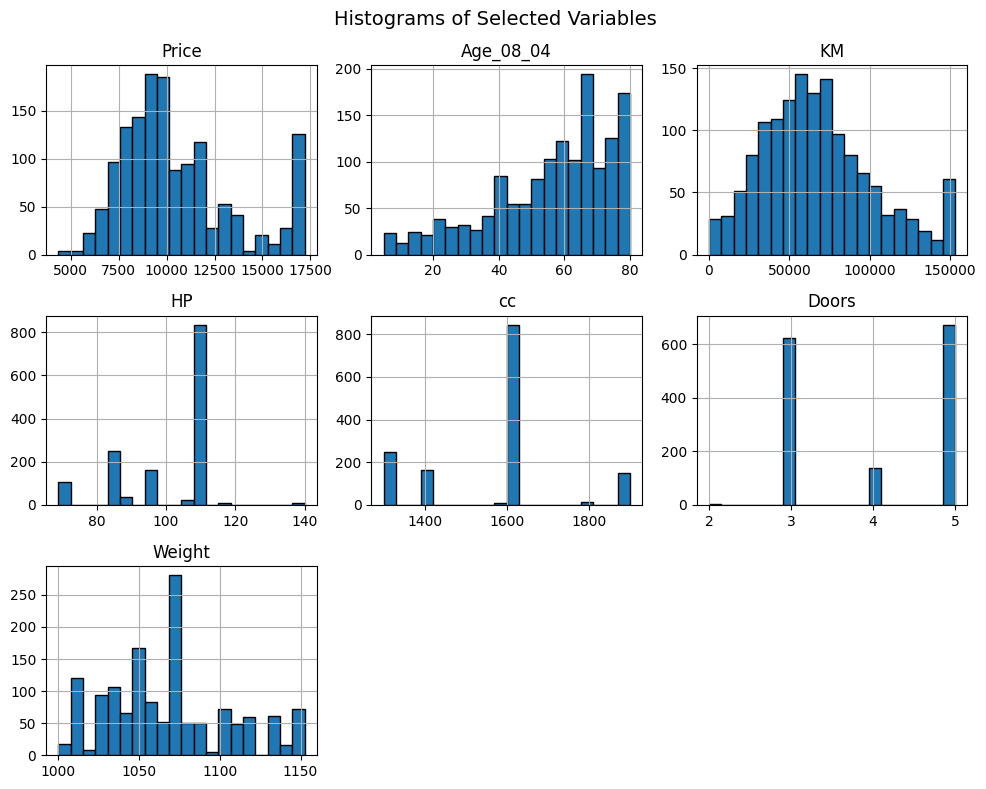

In [15]:
# Inspect individual variable shapes to detect skewness and inform transformations.
plt.figure(figsize=(10, 8))
hist_cols = ['Price', 'Age_08_04', 'KM', 'HP', 'cc', 'Doors', 'Weight']
autos_df[hist_cols].hist(figsize=(10, 8), bins=20, edgecolor='black')
plt.suptitle("Histograms of Selected Variables", fontsize=14)
plt.tight_layout()
plt.show()

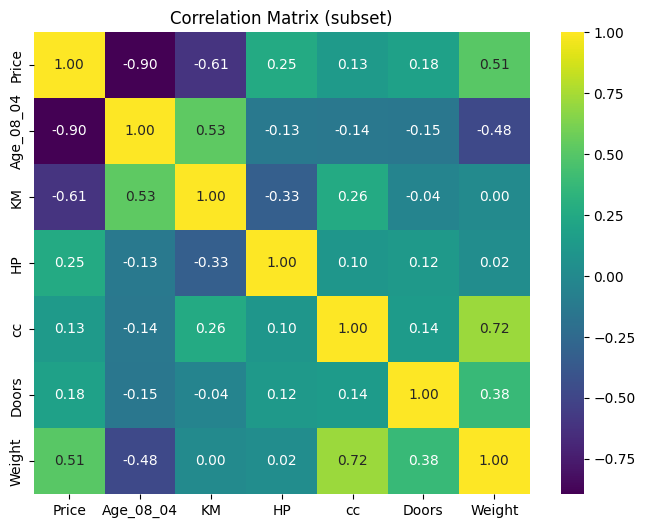

In [16]:
# Show pairwise linear relationships to reveal predictive signals and redundancy.
plt.figure(figsize=(8, 6))
corr_subset = autos_df[['Price', 'Age_08_04', 'KM', 'HP', 'cc', 'Doors', 'Weight']].corr()
sns.heatmap(corr_subset, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix (subset)")
plt.show()

In [17]:
# Select predictors and response exactly as required for the regression task.
features = autos_df[['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Automatic', 'cc', 'Doors', 'Weight']]
target = autos_df['Price']

In [18]:
# Create a hold-out test set to estimate how the model performs on new data.
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.80, random_state=100)
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

X_train shape: (1148, 8)
X_test  shape: (287, 8)


In [19]:
# Standardize numeric predictors so coefficients and penalties behave consistently.
std_scaler = StandardScaler()
numeric_cols = ['Age_08_04', 'KM', 'HP', 'Automatic', 'cc', 'Doors', 'Weight']
X_train[numeric_cols] = std_scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = std_scaler.transform(X_test[numeric_cols])

In [20]:
# Measure predictor redundancy because high multicollinearity destabilizes coefficients.
vif_table = pd.DataFrame()
vif_table["Feature"] = X_train.columns
vif_table["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_table

,Feature,VIF
0,Age_08_04,2.232647
1,KM,1.979083
2,Fuel_Type,1.025757
3,HP,1.269776
4,Automatic,NaN
5,cc,2.893016
6,Doors,1.285840
7,Weight,3.835221


In [21]:
# Fit OLS to estimate baseline predictive performance with the chosen features.
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
y_pred_test = ols_model.predict(X_test)
y_pred_train = ols_model.predict(X_train)

print("----- Linear Regression Results -----")
print("Train R² :", r2_score(y_train, y_pred_train))
print("Test R²  :", r2_score(y_test, y_pred_test))
print("MSE Test :", mean_squared_error(y_test, y_pred_test))

----- Linear Regression Results -----
Train R² : 0.8689916567072791
Test R²  : 0.8502399214923704
MSE Test : 1269017.886363077


In [22]:
n = X_test.shape[0]
p = X_test.shape[1]
r2 = r2_score(y_test, y_pred_test)
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
residuals = y_test - y_pred_test
rss = np.sum(residuals ** 2)
aic = n * np.log(rss / n) + 2 * p
bic = n * np.log(rss / n) + p * np.log(n)
print("Adjusted R²:", adj_r2)
print("AIC:", aic)
print("BIC:", bic)

Adjusted R²: 0.8459302789453882
AIC: 4049.4273524949886
BIC: 4078.7032102210655


In [23]:
# Apply L2 regularisation to shrink coefficients and reduce variance from correlated features.
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
print("\n----- Ridge Regression Results -----")
print("MSE (Ridge):", mean_squared_error(y_test, y_pred_ridge))
print("R2  (Ridge):", r2_score(y_test, y_pred_ridge))


----- Ridge Regression Results -----
MSE (Ridge): 1269354.9613385254
R2  (Ridge): 0.850200142403889


In [24]:
# Use L1 regularisation to encourage sparsity, simplifying the model by removing weak terms.
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso_test = lasso_model.predict(X_test)
y_pred_lasso_train = lasso_model.predict(X_train)
print("\n----- Lasso Regression Results -----")
print("Train R² (Lasso):", r2_score(y_train, y_pred_lasso_train))
print("Test R²  (Lasso):", r2_score(y_test, y_pred_lasso_test))
print("MSE Test (Lasso):", mean_squared_error(y_test, y_pred_lasso_test))


----- Lasso Regression Results -----
Train R² (Lasso): 0.8689916278259502
Test R²  (Lasso): 0.8502381055440646
MSE Test (Lasso): 1269033.27411463


#### Robust regression is needed only when outliers still influence the model strongly even after treating them.  
* Outliers have already been capped using the IQR range.  
* R² values remain steady for both training and testing sets.  
* The difference between train and test results is small, so overfitting is not present.

### Conclusion
- Linear Regression gives dependable baseline performance.  
- Ridge Regression improves overall stability and reduces variance in the model.  
- Lasso Regression performs in a similar range but also reduces weaker coefficients, which helps highlight less useful features.

### Interview Questions & Answers

1. What is Normalization and Standardization and how is it helpful?

Normalization  
- Converts data values to a fixed range, usually from 0 to 1.  
- Formula: (x - min) / (max - min).  
- Useful when feature scales vary widely, especially for distance-based algorithms like KNN and Neural Networks.

Standardization  
- Adjusts data to mean 0 and standard deviation 1.  
- Formula: (x - mean) / std.  
- Important for models like Linear Regression, Lasso, Ridge, and SVM where differing scales can distort coefficient values.

Why helpful?  
- Helps the model train efficiently.  
- Keeps all features on similar scale levels.  
- Prevents biased coefficient estimation.  
- Necessary for regularization-based models.

2. What techniques help reduce multicollinearity in Multiple Linear Regression?

Multicollinearity happens when independent variables are strongly related, making coefficients unstable.

Ways to handle it:

1. Variance Inflation Factor (VIF)  
   - Shows how much variance is inflated by correlation.  
   - Variables with VIF > 5 or 10 should be removed or modified.

2. Correlation Matrix  
   - Helps find features that move together strongly.  
   - Removing one of them reduces redundancy.

3. Ridge Regression (L2 Regularization)  
   - Shrinks coefficient sizes.  
   - Works well when predictors are correlated.

4. Lasso Regression (L1 Regularization)  
   - Eliminates weaker coefficients entirely.  
   - Useful when selecting important features and simplifying the model.